# "Implementation of Xception Model "
> "Paper and Pytorch Code discussion"

- toc: true
- badges: true
- comments: true
- categories: [Paper, deeplearning]
- author: Hitesh Kumar
- image: images/copied_from_nb/img/data.png

# What are we doing in this blog?


If you are here, then you know what are we doing. But still for the sake of clarity:

We are implementing popular Xception Network as represented by this [paper](https://arxiv.org/abs/1610.02357). In this blog, i'll be sharing my notes and learnings from this paper & Implemented code as well.


# Intro:


After GoogLeNet proposal of inception module have led in Surge of various improved inception network. In case, you are instantly thinking about the movie 'inception'. Yeah, that's right. It's taken from there. Convolutions within convolutions, this is inception module.

But what does inception module does differently?

It significantly reduces computational costs. Idea is not only about making accurate models but also making them deployable in outer world hardwares. Andrew Ng explains it the best in this [video](https://www.youtube.com/watch?v=C86ZXvgpejM).



Below, Image represents standard GoogLeNet proposed inception module. 1x1 for dimensions reductions. And later on we are concatenating the output of the each branch of `base`.

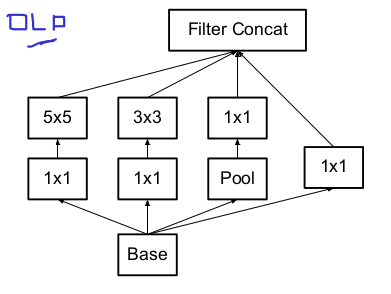

[Paper](https://arxiv.org/abs/1512.00567) - "Rethinking the Inception Architecture for Computer Vision" talks about getting rid of 5x5 convolutions and substituting it with two 3x3 convolution layers. This can result in dramatic decrease in computational costs from 120 millions to 1.2 million parameters & this is a giant leap of faith.
Author also suggests using asymmetric convolutions, e.g. n × 1. For example: using a 3 × 1 convolution followed by a 1 × 3 convolution
is equivalent to sliding a two layer network with the same receptive field as in a 3 × 3 convolution. But in practicality following issue was addressed in paper: `"we have found that employing this factorization does not work well on early layers, but it gives very good results on medium grid-sizes (On m × m feature maps, where
m ranges between 12 and 20)."`


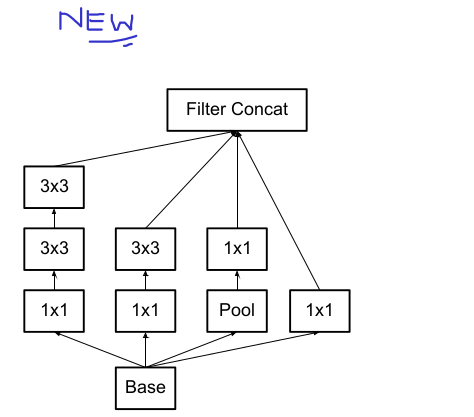

After that author of Xception [paper](https://arxiv.org/abs/1610.02357) brought new improvement in the module which gives more better compactness and fairly easy implementation in code.


But what is this xception?

Slightly different Xception is! Ofcourse, its an `extreme Inception module`.

# Xception complexity, yet simplicity:

Now after you have fair idea of what inception module looks like how it improved.

An “extreme” version of an Inception module, based on
this stronger hypothesis, would first use a 1x1 convolution to
map cross-channel correlations, and would then separately
map the spatial correlations of every output channel.

This might be easily explained with the help of image:

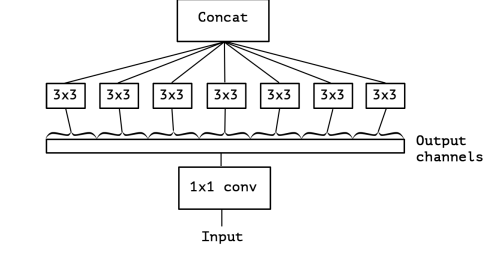

As you can see, Input (let's say 64x150x150) goes through 1x1 convolutions and the output of this uses various 3x3 convolutions. This seperately goes through every output channels. This is almost same as depthwise seperable convolutions. Commonly called
“separable convolution”. This is, a spatial convolution performed independently over each channel of an input, followed by a pointwise convolution, i.e. a 1x1 convolution, projecting the channels output by the depthwise convolution onto a new channel space.

Incase, this looks hard to under no worries we will understand it in code!
In tensorflow and keras it's pretty easy to deal with separable conv. But in pytorch we have to change only one parameter in normal `nn.Conv2d`. As follows: `nn.Conv2d(in_channel, out_channel,3, groups=in_channel, padding=1)`. 'groups' argument must be multiple of in_channel. This followed by  pointwise convolution will complete our aim.

In pytorch official documentation, (At the time of writing this blog) they don't say much about depthwise seperable conv.

In [ ]:
#hide
import torch
import torch.nn as nn


## DepthWise Separable Convolutions

Depthwise separable convolutions as usually implemented perform first channel-wise spatial convolution and then perform 1x1 convolution, whereas Inception performs the 1x1 convolution first. Below is a sample of how seperable Conv. is implemented --

Channel-wise spatial 3x3 convolution:
`nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1)`

Point-wise 1x1 convolution:
`nn.Conv2d(channels[0], channels[1],1)`

These will be used often in the Xception architecture. Before we proceed let's look at complete architecture so we know what are we doing..


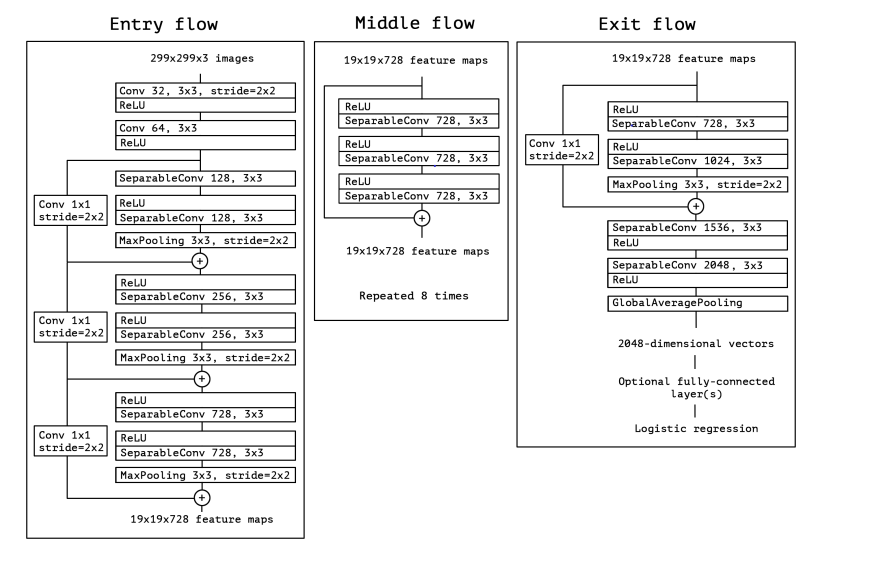

Dividing entire network into 3 sections:

- Entry Flow
- Middle Flow (repeated 8 times)
- Exit Flow

If you look closely, you will see skip connections also (i.e the Conv 1x1 layer which take previous input layer and adding in later layer). This is a bit similar with ResNet? Using residual layers and adding them up! This seen to significantly improve the accuracy of model without overfitting.  

We are first implementing DepthWiseSeperable.

> Note: Class DepthWiseSeperable include whole block between the skip connection as you can see in above image.

In class below we are taking channels list input. Which further will be used for parameters of seperable convolutions.

In [ ]:

class DepthWiseSeparable(nn.Module):
    def __init__(self, channels, middle_flow= False):
        super(DepthWiseSeparable, self).__init__()

        # block for entry flow
        if middle_flow== False:

            self.block= nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
                nn.BatchNorm2d(channels[1]),
                nn.MaxPool2d(3,stride=2, padding=1),
            )

        # block for middle flow
        if middle_flow==True:
            self.block= nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
                nn.BatchNorm2d(channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[1],1),
            )

        # block for exit flow

        if middle_flow=='Exit':
            self.block= nn.Sequential(
                nn.Conv2d(channels[0], channels[0],3, groups=channels[0], padding=1),
                nn.Conv2d(channels[0], channels[1],1),
                nn.BatchNorm2d( channels[1]),
                nn.ReLU(),
                nn.Conv2d( channels[1], channels[1],3, groups=channels[1], padding=1),
                nn.Conv2d( channels[1], channels[2],1),
                nn.BatchNorm2d(channels[2]),
                nn.ReLU(),
            )



    def forward(self,x):
        x= self.block(x)
        return x


Below is Main xception class which will use above class to create whole network.

In [ ]:

class Xception(nn.Module):
    def __init__(self, DepthWiseSeparable):
        super(Xception, self).__init__()

        self.conv1_3x3 = nn.Conv2d(3,32,3,stride=2,padding=1)
        self.bn1 =nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        self.conv2_3x3= nn.Conv2d(32,64,3,stride=1,padding=1)
        self.bn2 =nn.BatchNorm2d(64)
        self.relu= nn.ReLU()
        #Entry flow
        self.block_3x3= DepthWiseSeparable(channels=[64,128])
        self.downsample_1= nn.Conv2d(64,128,1,stride=2)

        self.block_3x3_256= DepthWiseSeparable(channels=[128,256])
        self.downsample_2= nn.Conv2d(128,256,1,stride=2)

        self.block_3x3_728= DepthWiseSeparable(channels=[256,728])
        self.downsample_3= nn.Conv2d(256,728,1,stride=2)
        #Middle Flow
        self.block_3x3_middle= DepthWiseSeparable(channels=[728,728], middle_flow=True)
        #Exit flow
        self.block_3x3_exit = DepthWiseSeparable(channels=[728,1024])
        self.downsample_4= nn.Conv2d(728,1024,1,stride=2)

        self.block_3x3_exit_2 = DepthWiseSeparable(channels=[1024,1536,2048], middle_flow='Exit')

        self.avgpool= nn.AdaptiveAvgPool2d((1,1))

        self.fc= nn.Linear(2048,1000)

    def forward(self,x):
        x= self.relu(self.bn1(self.conv1_3x3(x)))
        print(x.size())
        x_identity = self.relu(self.bn2(self.conv2_3x3(x)))
        print(x_identity.size())
        x_res_1= self.block_3x3(x_identity)
        print(x_res_1.size())
        x_identity= self.downsample_1(x_identity)
        print(x_identity.size())

        x_identity= x_identity+x_res_1

        x_res_2= self.block_3x3_256(x_identity)
        print(x_res_2.size())
        x_identity= self.downsample_2(x_identity)
        print(x_identity.size())

        x_identity= x_identity+x_res_2

        x_res_3= self.block_3x3_728(x_identity)
        print(x_res_3.size())
        x_identity= self.downsample_3(x_identity)
        print(x_identity.size())
        x_identity= x_identity+x_res_3

        for i in range(9):
            x_res_4= self.block_3x3_middle(x_identity)
            x_identity= x_identity+x_res_4

        print(x_identity.size())

        x_res_5= self.block_3x3_exit(x_identity)
        x_identity= self.downsample_4(x_identity)

        x_identity= x_identity+x_res_5
        print(x_identity.size())

        x_res_6= self.block_3x3_exit_2(x_identity)
        print(x_res_6.size())

        x= self.avgpool(x_res_6)
        print(x.size())

        x= x.view(x.shape[0],-1)
        print(x.size())

        x= self.fc(x)
        print(x.size())


In [ ]:
img= torch.randn(1,3,299,299)

net= Xception(DepthWiseSeparable)
net(img)

torch.Size([1, 32, 150, 150])
torch.Size([1, 64, 150, 150])
torch.Size([1, 128, 75, 75])
torch.Size([1, 128, 75, 75])
torch.Size([1, 256, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 728, 19, 19])
torch.Size([1, 728, 19, 19])
torch.Size([1, 728, 19, 19])
torch.Size([1, 1024, 10, 10])
torch.Size([1, 2048, 10, 10])
torch.Size([1, 2048, 1, 1])
torch.Size([1, 2048])
torch.Size([1, 1000])


In [ ]:
net

Xception(
  (conv1_3x3): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2_3x3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block_3x3): DepthWiseSeparable(
    (block): Sequential(
      (0): ReLU()
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (6): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): MaxPool2d(kernel_size=3, stride=2, padd